# A Python Notebook for _tagging_ charging stations with OSM data

We are building a list of charging stations used by users of the Belgian EV charging network we source data from.

Once we have these, we are _tagging_ these charging stations with data from OpenStreetMap (OSM). This notebook shows how carry out these tagging steps:

1. Preparations
    1. Building the list of charging stations and storing it as a GeoDataFrame
    2. Geospatial masking
    3. Cleaning up data
2. Tagging
    1. Distance based matching: Finding a (loose)match with already prepared OSM charging points
    2. Land use based matching: Finding a match with land use data
    3. Performing reverse geocoding
    4. Performing forward geocoding
3. Visual checks

Besides local and remote OSM API calls, we use the following data sources as well:
- Boundaries: https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/countries
- Static extracts from OSM: https://download.geofabrik.de/osm-data-in-gis-formats-free.pdf

In [2]:
# Importing Python libraries for dealing with DataFrames
import pandas as pd

# For path management and persisting data in feather format
from pathlib import Path
import pyarrow.feather as feather

# For dealing with spatial data and mapping
import geopandas as gpd
import plotly.express as px

# For dealing with JSON documents and parsing them
import json

# For calling OSM Overpass and Nominatim APIs
import overpy
import requests

# Images in notebooks (for GitHub publishing)
from IPython.display import Image


## Getting a list of charging stations from the usage data collected by the network operator

Loading previously persisted datasets, picking the attributes we need and concatenating them.

In [3]:
internal_users = feather.read_feather(
    Path.joinpath(Path.cwd(), "data", "NETWORK_OPERATOR", "Charging sessions and service records (BBS).feather")
)

#internal_users.info()

In [4]:
external_users = feather.read_feather(
    Path.joinpath(Path.cwd(), "data", "NETWORK_OPERATOR", "Charging sessions (ABS).feather")
)

#external_users.info()

Selecting the attributes that we'll need for this part.

Wwe are only interested in location related information at this time:

- `evse_id`
- `latitude`
- `longitude`
- `zip code`
- `town`
- `country`

Building a combined charging station sessions dataset.

In [5]:
# Concatenate the two DataFrames
charging_sessions = pd.concat(
    [
        internal_users[
            ["evse_id", "latitude", "longitude", "zip code", "town", "country"]
        ],
        external_users[
            ["evse_id", "latitude", "longitude", "zip code", "town", "country"]
        ],
    ]
)

# Let's have a look at what we have
charging_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182887 entries, 0 to 130194
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   evse_id    182887 non-null  object 
 1   latitude   171325 non-null  float64
 2   longitude  171325 non-null  float64
 3   zip code   182727 non-null  object 
 4   town       182727 non-null  object 
 5   country    182887 non-null  object 
dtypes: float64(2), object(4)
memory usage: 9.8+ MB


In this notebook we will be focusing only on charging stations and not really on charging sessions. Keeping one record only for each station, by dropping duplicates.

In [6]:
# Before naiive cleaning
print(charging_sessions.shape)

# Remove duplicates and have a look at the sahpe again
charging_sessions.drop_duplicates(inplace=True)
print(charging_sessions.shape)

# There are a few stations that are incorrectly tagged (e.g., city name) but still a valid one
charging_sessions.drop_duplicates(
    subset=["evse_id", "latitude", "longitude"], inplace=True
)

# Again, we are looking at charging stations, so let's copy the dataframe
charging_stations = charging_sessions.copy()

# Finally, we have this amount of distinct charging stations
print(charging_stations.shape)

(182887, 6)
(9514, 6)
(9494, 6)


## Geospatial masking

Using EUROSTAT boundary data to perform a spatial "clip"

In [7]:
# Getting country boundaries from Eurostat
belgium_gdf = gpd.read_file(
    Path.joinpath(
        Path.cwd(),
        "data",
        "EUROSTAT-ref-countries-2020-01m-shp",
        "CNTR_RG_01M_2020_4326",
        "CNTR_RG_01M_2020_4326.shp",
    )
)

# Our focus is only on Belgium, so we filter out the other countries
belgium_gdf = belgium_gdf[belgium_gdf["CNTR_ID"] == "BE"]

# The shape should arrive in WGS84 / EPSG:4326, but making sure we are using the right projection
belgium_gdf = belgium_gdf.to_crs("EPSG:4326")
belgium_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

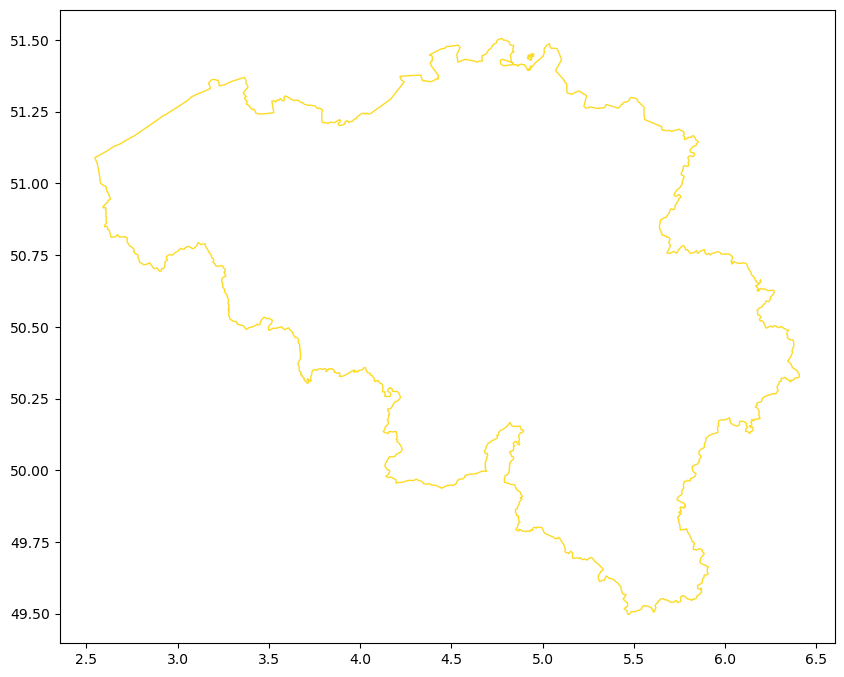

In [8]:
# Let's see a dummy plot of the shapefile
belgium_gdf.plot(
    figsize=(10, 10), color="white", edgecolor="#fdda24" # yellow of the Belgian flag
)  

### Mapping the dataset before cleaning

For a quick visual check, let's plot all the collected charging stations on a map.

We can see that there are a number of them outside of the country, that we will need to remove.

Additionally, there are a few odd outliers as well: Look at the one in Paris, France, for example. Is it really marked as a Belgian station?

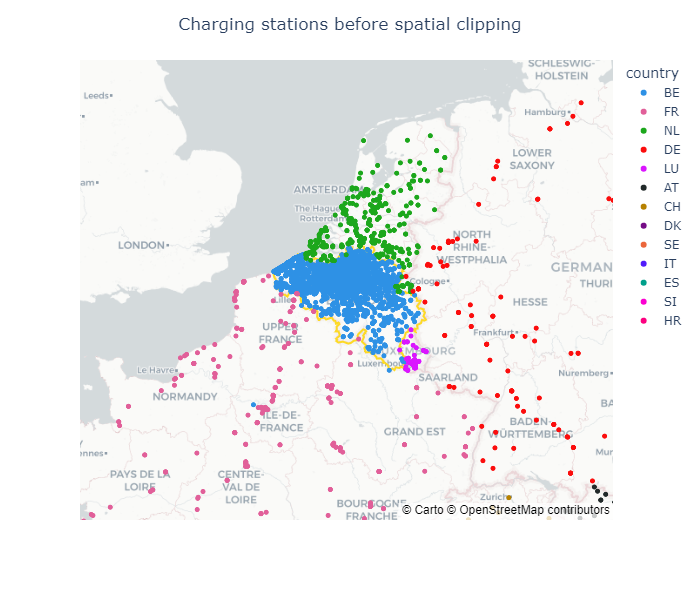

In [9]:
# Need to set my MapBox token
px.set_mapbox_access_token(open(".mapbox_token").read())

# Scatter plot of the charging stations
fig = px.scatter_mapbox(
    charging_stations,
    lat="latitude",
    lon="longitude",
    hover_name="evse_id",
    color="country",
    center=dict(lat=50.8, lon=4.4),
    color_discrete_sequence=px.colors.qualitative.Dark24,
)

# Some map settings and adding a layer with the Belgian border
fig.update_layout(
    title="Charging stations before spatial clipping",
    title_x=0.5,
    mapbox={
        "style": "carto-positron",
        "zoom": 4.8,
        "layers": [
            # A layer with the Belgian border
            {
                "sourcetype": "geojson",
                "source": json.loads(
                    belgium_gdf.geometry.to_json()
                ),  # we need to use json.loads to convert the string to a proper Python dictionary
                "below": "traces",
                "type": "line",
                "color": "#fdda24",  # yellow of the Belgian flag
                "line": {"width": 2.0},
            }
        ],
    },
    paper_bgcolor="#ffffff",
    height=600,
)

#fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## Cleaning up data

We can see that there are some oddities in the data, such as:
- Some stations have no location information (nulls)
- Some stations have coordinates that are not even in Europe
- Some stations have invalid coordinates (zeros)

We cannot really do anything with charging stations that have no or invalid location information. Let's drop those.

In [10]:
# Dropping charging station with no coordinates
charging_stations.dropna(subset=["latitude", "longitude"], inplace=True)

charging_stations.shape

(8417, 6)

In [11]:
# Dropping charging stations with coordinates (0,0)
charging_stations = charging_stations[
    ~((charging_stations["latitude"] == 0) & (charging_stations["longitude"] == 0))
]

charging_stations.shape

(8375, 6)

### Removing stations that are outside of Belgium

First, creating a GeoDataFrame from the charging stations dataset

Afterwards, performing a simple spatial clip with the mask of the Belgian border

Note: We have to make sure that the same projection (EPSG:4326) is used 

In [12]:
# Let's use the data frame as a GeoDataFrame from now on
charging_stations = gpd.GeoDataFrame(
    data=charging_stations,
    geometry=gpd.points_from_xy(
        charging_stations.longitude, charging_stations.latitude
    ),
    crs="EPSG:4326",
)

# Before clipping
print(charging_stations.shape)

# Clipping with the border shape
charging_stations = charging_stations.clip(belgium_gdf)

# After clipping
print(charging_stations.shape)

(8375, 7)
(7128, 7)


### A map for a visual check

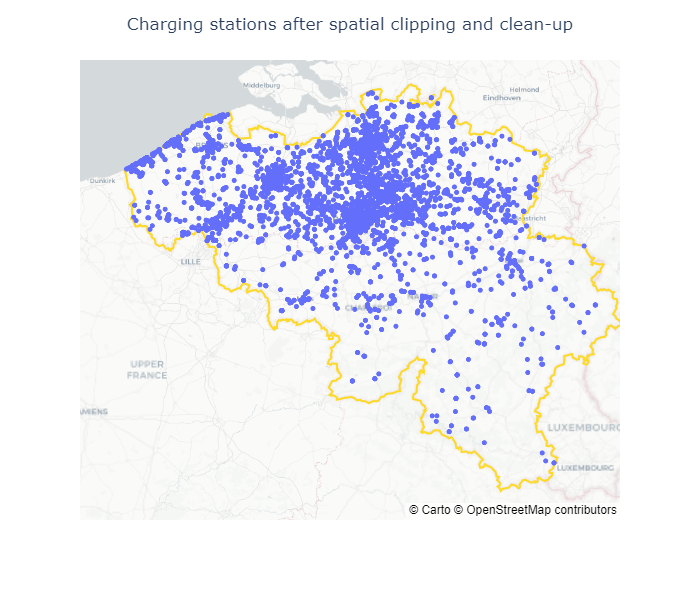

In [13]:
# Scatter plot of the charging stations
fig = px.scatter_mapbox(
    charging_stations,
    lat="latitude",
    lon="longitude",
    hover_name="evse_id",
    center=dict(lat=50.5, lon=4.3),
)

# Some map settings and adding a layer with the Belgian border
fig.update_layout(
    title="Charging stations after spatial clipping and clean-up",
    title_x=0.5,
    mapbox={
        "style": "carto-positron",
        "zoom": 6.5,
        "layers": [
            # Belgian border
            {
                "sourcetype": "geojson",
                "source": json.loads(
                    belgium_gdf.geometry.to_json()
                ),  # we need to use json.loads to convert the string to a proper Python dictionary
                "below": "traces",
                "type": "line",
                "color": "#fdda24",  # yellow of the Belgian flag
                "line": {"width": 2.0},
            }
        ],
    },
    paper_bgcolor="#ffffff",
    height=600,
)

#fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## Tagging stations with data from OSM

In case we can match a station from the "usage dataset" with a station from the "OSM charging stations dataset", we mark the "osm_amenity_type" and the distance from the amenity in meters.

A "match" can mean:
- The station is in the exact same location (coordinates match)
- The station is in the vicinity of the OSM station (coordinates are within a certain distance while the zip code is the same)

We are using a 50m radius for looking up stations in the vicinity.

First, Let's get the charging stations from the feather file we created earlier and build a geodataframe from it.

In [14]:
# Reading the feather file
osm_charging_stations = feather.read_feather(
    Path.joinpath(Path.cwd(), "data", "Charging_Stations_from_OSM.feather")
)

# Keeping only "node" elements
osm_charging_stations = osm_charging_stations[osm_charging_stations["type"] == "node"]

# Converting latitude and longitude to numeric
osm_charging_stations["latitude"] = pd.to_numeric(osm_charging_stations["latitude"])
osm_charging_stations["longitude"] = pd.to_numeric(osm_charging_stations["longitude"])

# Converting it to a GeoDataFrame using the coordinates
osm_charging_stations = gpd.GeoDataFrame(
    data=osm_charging_stations,
    geometry=gpd.points_from_xy(
        osm_charging_stations.longitude, osm_charging_stations.latitude
    ),
    crs="EPSG:4326",
)
# Let's see what we have now
osm_charging_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2613 entries, 0 to 2612
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osm_id     2613 non-null   int64   
 1   type       2613 non-null   object  
 2   latitude   2613 non-null   float64 
 3   longitude  2613 non-null   float64 
 4   amenity    2613 non-null   object  
 5   geometry   2613 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 142.9+ KB


In [15]:
# Checking projections
print(osm_charging_stations.crs)
print(charging_stations.crs)

EPSG:4326
EPSG:4326


### Tagging: Distance based matching
Naiive method: Looping over all stations and checking if there is an match in the OSM dataset using pre-set static radius.

`sjoin_nearest` is used for this step with a `max_distance` of 50m.

In [16]:
# This is what we have before this step
charging_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7128 entries, 4631 to 22828
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   evse_id    7128 non-null   object  
 1   latitude   7128 non-null   float64 
 2   longitude  7128 non-null   float64 
 3   zip code   7124 non-null   object  
 4   town       7124 non-null   object  
 5   country    7128 non-null   object  
 6   geometry   7128 non-null   geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 445.5+ KB


In [17]:
MAX_DISTANCE = 50  # meters

# For the spatial join with nearest, we will use projection BD72 / Belgian Lambert 72 (EPSG:31370)
# Distance will be given in meters with the right accuracy

charging_stations = (
    charging_stations.to_crs("EPSG:31370")
    .sjoin_nearest(
        osm_charging_stations.to_crs("EPSG:31370"),
        how="left",
        lsuffix="network_operator",
        rsuffix="osm",
        distance_col="amenity_distance",
        max_distance=MAX_DISTANCE,
    )
    .to_crs("EPSG:4326")
)

In [18]:
# A quick clean-up of resulting columns

# We do not need these any more
charging_stations.drop(columns=["index_osm", "type", "country"], inplace=True)

# Renaming columns
charging_stations.rename(
    columns={
        "osm_id": "amenity_osm_id",
        "osm_amenity": "amenity",
        "latitude_network_operator": "latitude",
        "longitude_network_operator": "longitude",
        "latitude_osm": "amenity_latitude",
        "longitude_osm": "amenity_longitude",
    },
    inplace=True,
)

In [19]:
# We cannot show the `evse_id` in our public repository, sorry
charging_stations[charging_stations.columns.difference(['evse_id'])].sample(5, random_state=42)

,amenity,amenity_distance,amenity_latitude,amenity_longitude,amenity_osm_id,geometry,latitude,longitude,town,zip code
100368,NaN,NaN,NaN,NaN,NaN,POINT (4.36081 50.84609),50.846092,4.360808,Brussel,1000
7288,NaN,NaN,NaN,NaN,NaN,POINT (3.72853 51.05140),51.051395,3.728528,Gent,9000
51966,NaN,NaN,NaN,NaN,NaN,POINT (4.12444 51.22344),51.223439,4.124442,Sint-Gillis-Waas,9170
17262,charging_station,3.053126,51.320747,4.950899,9.825274e+09,POINT (4.95089 51.32072),51.320721,4.950886,Turnhout,2300
63655,NaN,NaN,NaN,NaN,NaN,POINT (4.49661 50.87807),50.878068,4.496610,Zaventem,1930


### Tagging: Land use based matching

The following code snippet is used to tag stations with the land use type of the area they are located in.

First, we are loading the landuse data from the `gis_osm_landuse_a_free_1.shp` shapefile. Then persisting it with feather that can be loading in a matter of seconds. (Note: the first block needs to be executed only once, so it is commented for now.)

In [20]:
# Loading the OSM land use shapefile (takes approx 7-8 minutes)

# this block is commented out because it takes a long time to run
# needs to be executed once, then the result can be loaded from the feather file

#belgium_landuse_gdf = gpd.read_file(Path.joinpath(Path.cwd(), 'data', 'OSM-belgium-230801-free-shp', 'gis_osm_landuse_a_free_1.shp'))

# writing the geometry collections to a file

#belgium_landuse_gdf.to_feather(Path.joinpath(Path.cwd(), 'data', 'OSM-belgium-230801-free-shp.feather'))

Let's use the persisted landuse file (we assume that the previous step was already executed and the file exists).

In [21]:
# loading the same info using feather takes approx. 5 seconds
belgium_landuse_gdf = gpd.read_feather(
    Path.joinpath(Path.cwd(), "data", "OSM", "OSM-belgium-230801-free-shp.feather")
)

In [22]:
# some basic info on the shape
belgium_landuse_gdf.info()
belgium_landuse_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 999178 entries, 0 to 999177
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osm_id    999178 non-null  object  
 1   code      999178 non-null  int64   
 2   fclass    999178 non-null  object  
 3   name      15015 non-null   object  
 4   geometry  999178 non-null  geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 38.1+ MB


,osm_id,code,fclass,name,geometry
0,3516686,7202,park,Minnewaterpark,"POLYGON ((3.22407 51.19835, 3.22414 51.19846, ..."
1,3517578,7202,park,Parc de Bruxelles - Warandepark,"POLYGON ((4.36072 50.84331, 4.36072 50.84333, ..."
2,4004829,7218,grass,None,"POLYGON ((4.69809 50.86982, 4.69812 50.87009, ..."
3,4005361,7202,park,Middenbermpark,"POLYGON ((4.69876 50.86857, 4.69882 50.86863, ..."
4,4228427,7202,park,None,"POLYGON ((5.70046 50.97129, 5.70093 50.97148, ..."


We can also check the unique options a landuse can have in Belgium, the values of the `fclass` attribute.

In [23]:
belgium_landuse_gdf.fclass.unique()

array(['park', 'grass', 'cemetery', 'forest', 'meadow', 'industrial',
       'nature_reserve', 'residential', 'farmland', 'recreation_ground',
       'commercial', 'farmyard', 'scrub', 'quarry', 'allotments',
       'retail', 'orchard', 'military', 'heath', 'vineyard'], dtype=object)

We are joining the the charging stations with the landuse data using predicate `intersects`. This means that we are looking for the landuse type of the area that the station is located in.

In [24]:
charging_stations = charging_stations.sjoin(
    belgium_landuse_gdf.reset_index(drop=True),
    how="left",
    rsuffix="landuse",
    predicate="intersects",
)
charging_stations.drop(columns=["index_landuse", "code", "name"], inplace=True)
charging_stations.rename(
    columns={"fclass": "landuse_fclass", "osm_id": "landuse_osm_id"}, inplace=True
)

charging_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7229 entries, 4631 to 22828
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   evse_id            7229 non-null   object  
 1   latitude           7229 non-null   float64 
 2   longitude          7229 non-null   float64 
 3   zip code           7225 non-null   object  
 4   town               7225 non-null   object  
 5   geometry           7229 non-null   geometry
 6   amenity_osm_id     1386 non-null   float64 
 7   amenity_latitude   1386 non-null   float64 
 8   amenity_longitude  1386 non-null   float64 
 9   amenity            1386 non-null   object  
 10  amenity_distance   1386 non-null   float64 
 11  landuse_osm_id     5421 non-null   object  
 12  landuse_fclass     5421 non-null   object  
dtypes: float64(6), geometry(1), object(6)
memory usage: 790.7+ KB


In [25]:
charging_stations[charging_stations.columns.difference(['evse_id'])].sample(5, random_state=42)

,amenity,amenity_distance,amenity_latitude,amenity_longitude,amenity_osm_id,geometry,landuse_fclass,landuse_osm_id,latitude,longitude,town,zip code
4923,charging_station,6.990305,50.837384,4.350185,7.935099e+09,POINT (4.35028 50.83741),residential,399556868,50.837409,4.350276,Brussel,1000
84922,NaN,NaN,NaN,NaN,NaN,POINT (5.31702 51.22479),residential,1005408915,51.224786,5.317023,Lommel,3920
28064,NaN,NaN,NaN,NaN,NaN,POINT (3.72967 51.04793),NaN,NaN,51.047931,3.729672,Gent,9000
6957,NaN,NaN,NaN,NaN,NaN,POINT (4.54646 51.21002),NaN,NaN,51.210020,4.546460,Ranst,2160
6733,NaN,NaN,NaN,NaN,NaN,POINT (4.45839 50.82994),residential,30125665,50.829940,4.458390,Sint-Pieters-Woluwe,1150


### Tagging: Reverse geocoding

Via reverse geocoding we are trying to get the address (or in our case, the OSM amenity) of the charging station. For this task, we are not using `OSMPythonTools` or `geopy`, but relying on the Nominatim API directly. This is to be able to get results in jsonv2 format, which is not supported by these libraries.

Before executing this job, we
- either need to have a local instance of Nominatim up with the Belgian OSM dataset, or
- have non-ratelimited access to a public service that offers the Nominatim API.

We could bring online a local replica in a container by using the following command:

```bash
podman run -it --shm-size=1g -e PBF_PATH=/nominatim/data/belgium-230801.osm.pbf -e IMPORT_WIKIPEDIA=true -e FREEZE=true -e IMPORT_STYLE=extratags -p 8080:8080 -v c:\Users\agelanyi\Data\OSM:/nominatim/data --name nominatim  mediagis/nominatim:4.2
```

Let's define a _lookup_ function that we will call for every station. We will call `nominatim_reverse()` when iterating on the stations of our dataframe.

In [26]:
def nominatim_reverse(latitude, longitude, zoom=18, format="jsonv2"):
    response = requests.get(
        "http://localhost:8080/reverse",
        params={"lat": latitude, "lon": longitude, "zoom": zoom, "format": format},
    ).json()
    ret = {}
    ret["reverse_osm_id"] = response.get("osm_id")
    ret["reverse_osm_type"] = response.get("osm_type")
    ret["reverse_category"] = response.get("category")
    ret["reverse_type"] = response.get("type")
    return ret

Now, we are ready to call the API. For every station we have in the dataset, we are calling the Nominatim API and storing the result in a dictionary.

In [27]:
# Block runs for approx. 4-5 minutes

# Performs a reverse geocoding of the charging stations
charging_stations_reverse = charging_stations.apply(lambda x: nominatim_reverse(x.latitude, x.longitude), axis=1, result_type='expand')

# Merging the results with the original data frame
charging_stations = pd.concat([charging_stations, charging_stations_reverse], axis=1)

In [28]:
charging_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7229 entries, 4631 to 22828
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   evse_id            7229 non-null   object  
 1   latitude           7229 non-null   float64 
 2   longitude          7229 non-null   float64 
 3   zip code           7225 non-null   object  
 4   town               7225 non-null   object  
 5   geometry           7229 non-null   geometry
 6   amenity_osm_id     1386 non-null   float64 
 7   amenity_latitude   1386 non-null   float64 
 8   amenity_longitude  1386 non-null   float64 
 9   amenity            1386 non-null   object  
 10  amenity_distance   1386 non-null   float64 
 11  landuse_osm_id     5421 non-null   object  
 12  landuse_fclass     5421 non-null   object  
 13  reverse_osm_id     7229 non-null   int64   
 14  reverse_osm_type   7229 non-null   object  
 15  reverse_category   7229 non-null   object  
 16 

### Tagging: Forward geocoding

Getting the number of amenities in the vicinity of the location. Finding _charging_station_ type amenities and calculating nearby capacity. We are calling the `Overpass` OpenStreetMap API for this task using the `overpy` module.

First, we are defining the `count_amenities_nearby()` function that we will call for every station. There are a few tricks here:
- We are using the `around` predicate to find _amenities_ in the vicinity of the station
- In case there are _charging_station_ type amenities nearby, we are looking at each of these and summing the capacity. A few things to note here:
    - If the capacity is greater than 30, we are considering it incorrect (the mapper most probably considered the power of the station, not the number of plugs)
    - If the capacity cannot be converted as it is not a poprer number, we are trying to take the first character of the string, which is most probably a number
    - If the capacity is still not a number, we are considering it as 1

Similarly, before executing this job, we
- either need to have a local instance of Opverpass API services up with the Belgian OSM dataset, or
- have non-ratelimited access to a public service that offers the Overpass API.

This latter, however, is generally not available for the number of requests we need to make. We could bring online a local replica in a container by using the following command:

```bash
podman run -e OVERPASS_META=yes -e OVERPASS_MODE=init -e OVERPASS_PLANET_URL=http://download.geofabrik.de/europe/belgium-230825.osm.bz2 -v c:\Users\agelanyi\Data\OSM\overpass_belgium_db/:/db -p 8081:80 -i -t --name overpass wiktorn/overpass-api
```


In [29]:
# We use the Overpass API to query the OpenStreetMap database

# Default public instance of the Overpass API
# overpass_api = overpy.Overpass()

# Local instance of the Overpass API with data from Geofabrik for Belgium
overpass_api = overpy.Overpass(url="http://localhost:8081/api/interpreter")


# Defining a function to count the number of amenities within a given radius
def count_amenities_nearby(lat, lon, radius):
    results = overpass_api.query(
        f"""
            [out:json][timeout:25];
            (
            nwr
            [amenity]
            (around:{radius},{lat},{lon});
            );
            out count; // cannot be used via overpy :(
            out body;
        """
    )

    charging_capacity_near = 0
    for node in results.nodes:
        if node.tags.get("amenity") == "charging_station":
            if node.tags.get("capacity") is not None:
                # Sometimes the capacity is incorrectly set, not as a number but a string (e.g., "2x 11 kW")
                # This affects a small number of stations (3 in the current dataset)
                cap = node.tags.get("capacity")
                try:
                    # taking the capacity value if it is a number
                    if int(cap) < 30:
                        charging_capacity_near += int(cap)
                    else:
                        print(
                            f"Capacity '{cap}' seems to be incorrect. (kW perhaps?) Skipping and simply adding 1 as charging capacity."
                        )
                        charging_capacity_near += 1
                except ValueError:
                    # alternatively, taking the first character if it is a string and trying to convert it to a number
                    print(
                        f"Cannot convert '{cap}'. Trying to use the first character '{cap[0]}' only."
                    )
                    try:
                        charging_capacity_near += int(cap[0])
                    except ValueError:
                        # otherwise, simply adding 1 as charging capacity as we do not know anything else about the station
                        print(
                            f"Could not convert '{cap[0]}' to int either. Skipping and simply adding 1 as charging capacity."
                        )
                        charging_capacity_near += 1
            else:
                # in case the capacity is not set, we simply add 1 as charging capacity
                charging_capacity_near += 1

    # returning the overall number of amenities and the charging capacity
    return {
        "amenities_near": len(results.nodes)
        + len(results.ways)
        + len(results.relations),
        "charging_capacity_near": charging_capacity_near,
    }

Now, let's call the Overpass API for every station in the dataset. Final resultset is concatenated with the original dataset.

In [30]:
# Runs for approx. 25-30 minutes

RADIUS = 50.0 # meters

charging_stations_amenities_near = charging_stations.apply(lambda x: count_amenities_nearby(x.latitude, x.longitude, RADIUS), axis=1, result_type='expand')
charging_stations = pd.concat([charging_stations, charging_stations_amenities_near], axis=1)


Capacity '184' seems to be incorrect. (kW perhaps?) Skipping and simply adding 1 as charging capacity.
Capacity '184' seems to be incorrect. (kW perhaps?) Skipping and simply adding 1 as charging capacity.
Cannot convert '2x 11 kW'. Trying to use the first character '2' only.
Cannot convert '2x 11 kW'. Trying to use the first character '2' only.
Cannot convert '2x 11 kW'. Trying to use the first character '2' only.
Capacity '32' seems to be incorrect. (kW perhaps?) Skipping and simply adding 1 as charging capacity.
Capacity '60' seems to be incorrect. (kW perhaps?) Skipping and simply adding 1 as charging capacity.
Capacity '60' seems to be incorrect. (kW perhaps?) Skipping and simply adding 1 as charging capacity.
Capacity '320' seems to be incorrect. (kW perhaps?) Skipping and simply adding 1 as charging capacity.
Capacity '320' seems to be incorrect. (kW perhaps?) Skipping and simply adding 1 as charging capacity.
Capacity '50' seems to be incorrect. (kW perhaps?) Skipping and simpl

In [31]:
# Let's see what we have now
charging_stations[charging_stations.columns.difference(['evse_id'])].sample(5, random_state=42)

,amenities_near,amenity,amenity_distance,amenity_latitude,amenity_longitude,amenity_osm_id,charging_capacity_near,geometry,landuse_fclass,landuse_osm_id,latitude,longitude,reverse_category,reverse_osm_id,reverse_osm_type,reverse_type,town,zip code
4923,8,charging_station,6.990305,50.837384,4.350185,7.935099e+09,8,POINT (4.35028 50.83741),residential,399556868,50.837409,4.350276,highway,702779548,way,pedestrian,Brussel,1000
84922,0,NaN,NaN,NaN,NaN,NaN,0,POINT (5.31702 51.22479),residential,1005408915,51.224786,5.317023,building,141369889,way,house,Lommel,3920
28064,23,NaN,NaN,NaN,NaN,NaN,0,POINT (3.72967 51.04793),NaN,NaN,51.047931,3.729672,amenity,9795298710,node,vending_machine,Gent,9000
6957,2,NaN,NaN,NaN,NaN,NaN,0,POINT (4.54646 51.21002),NaN,NaN,51.210020,4.546460,building,387806907,way,retail,Ranst,2160
6733,1,NaN,NaN,NaN,NaN,NaN,0,POINT (4.45839 50.82994),residential,30125665,50.829940,4.458390,building,266120937,way,yes,Sint-Pieters-Woluwe,1150


### Persisting the tagged Data Frame with geometry to a feather file

We have the enriched and tagged charging stations dataset ready. Let's persist it to a feather file for later use.

In [32]:
# Somehow, we need to cast the evse_id to string, otherwise it will be treated as an int and serialization will fail
charging_stations.astype({"evse_id": "str"}).to_feather(
    Path.joinpath(Path.cwd(), "data", "private", "Charging stations.feather")
)

## Quick visual check of distributions

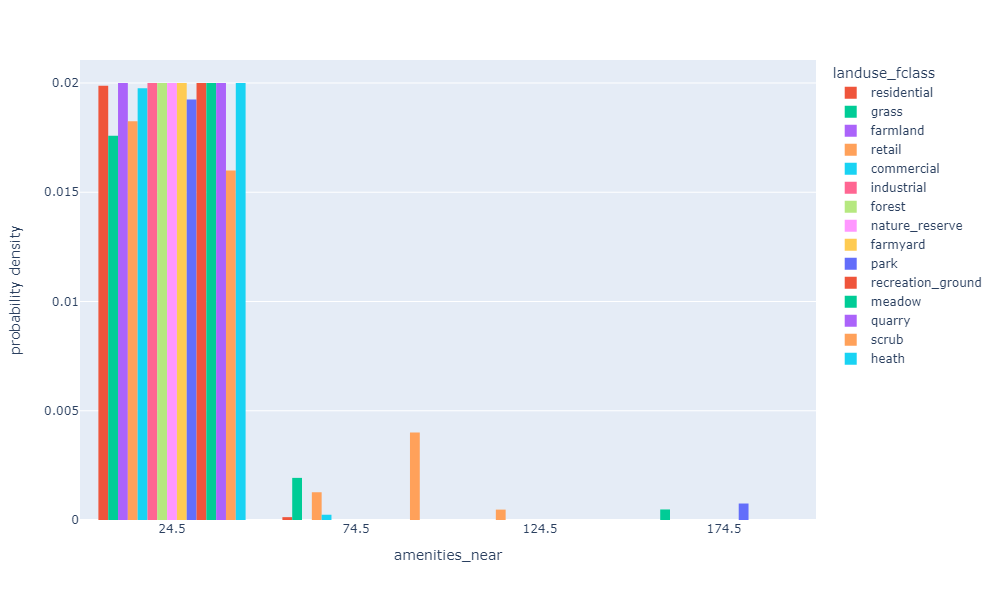

In [33]:
# Loading the data
charging_stations = gpd.read_feather(Path.joinpath(Path.cwd(), "data", "private", "Charging stations.feather"))

# A simple histogram of the number of amenities nearby
fig = px.histogram(
    charging_stations,
    x="amenities_near",
    color="landuse_fclass",
    barmode="group",
    #histnorm="percent",
    histnorm='probability density',
    nbins=6,
    height=600, width=1000,
)

#fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)